In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('ai4i2020.csv')

# Inspect the data
print(df.head())
print(df.info())
print(df['Machine failure'].value_counts())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [5]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b6591c09ef9855ceb9d99f37d13542bab226985a0e982987fa8c0e62bbc7bf9b
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
Air temperature [K]      0.488208   1.629394  0.057392        0.375722   
Process temperature [K] -0.493753   0.610332  0.077402       -0.645457   
Rotational speed [rpm]   0.008014   1.008046  0.000340        0.007348   
Torque [Nm]              0.199958   1.221352  0.007230        0.185788   
Type_L                   0.531512   1.701504  0.229749        0.081213   
Type_M                   0.289601   1.335894  0.245805       -0.192168   

                         coef upper 95%  exp(coef) lower 95%  \
covariate                                                      
Air temperature [K]            0.600695             1.456042   
Process temperature [K]       -0.342049             0.524423   
Rotational speed [rpm]         0.008680             1.007375   
Torque [Nm]                    0.214128             1.204167   
Type_L                 

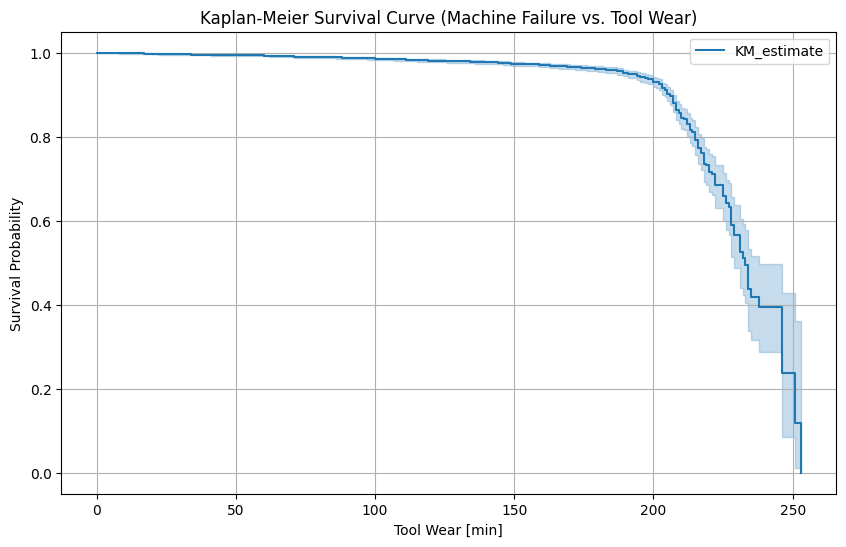

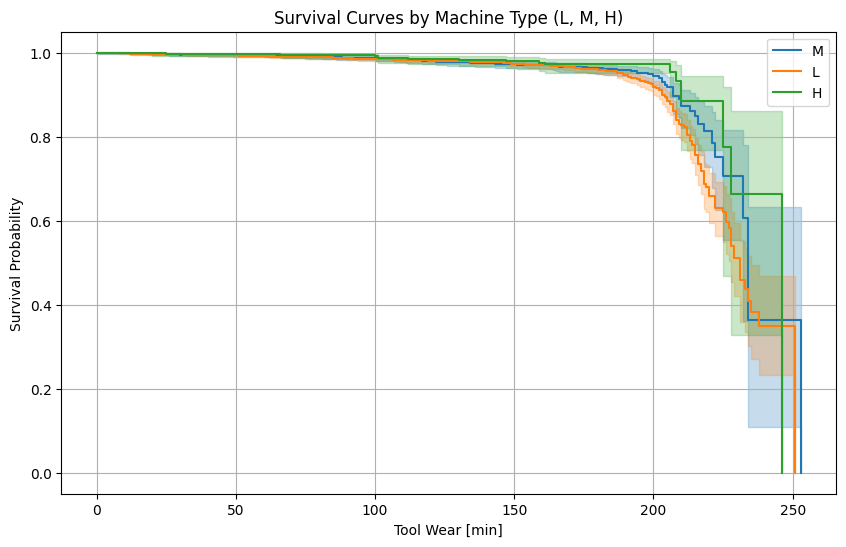

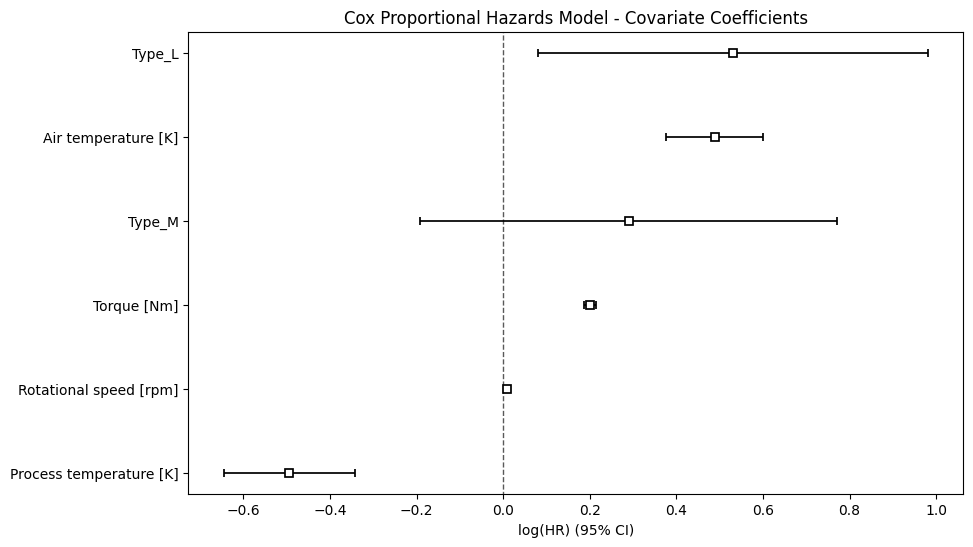

In [7]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# Prepare data for Survival Analysis
# We'll use 'Tool wear [min]' as the duration and 'Machine failure' as the event
survival_df = df[['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']]

# Kaplan-Meier Curve (Overall)
kmf = KaplanMeierFitter()
kmf.fit(durations=survival_df['Tool wear [min]'], event_observed=survival_df['Machine failure'])

# Plot KM Curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve (Machine Failure vs. Tool Wear)')
plt.xlabel('Tool Wear [min]')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.savefig('survival_km_plot.png')

# KM Curve by Machine Type
plt.figure(figsize=(10, 6))
for machine_type in survival_df['Type'].unique():
    subset = survival_df[survival_df['Type'] == machine_type]
    kmf.fit(durations=subset['Tool wear [min]'], event_observed=subset['Machine failure'], label=machine_type)
    kmf.plot_survival_function()
plt.title('Survival Curves by Machine Type (L, M, H)')
plt.xlabel('Tool Wear [min]')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.savefig('survival_by_type.png')

# Cox Proportional Hazards Model
# Preprocessing: Convert Type to dummy variables
survival_df_dummies = pd.get_dummies(survival_df, columns=['Type'], drop_first=True)

cph = CoxPHFitter()
cph.fit(survival_df_dummies, duration_col='Tool wear [min]', event_col='Machine failure')

# Print summary of CoxPH
cph_summary = cph.summary
print(cph_summary)

# Plot CoxPH Coefficients
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Cox Proportional Hazards Model - Covariate Coefficients')
plt.savefig('cox_hazard_coefficients.png')

# Show median survival time
median_survival = kmf.median_survival_time_
print(f"Median Survival Time (Tool Wear): {median_survival} minutes")

Model AUC: 0.9080
Coefficients:
Process temperature [K]   -1.198877
Tool wear [min]            0.872298
Rotational speed [rpm]     1.735670
Air temperature [K]        1.748740
Torque [Nm]                2.420522
dtype: float64
95% Survival Tool Wear: 191 min
90% Survival Tool Wear: 206 min


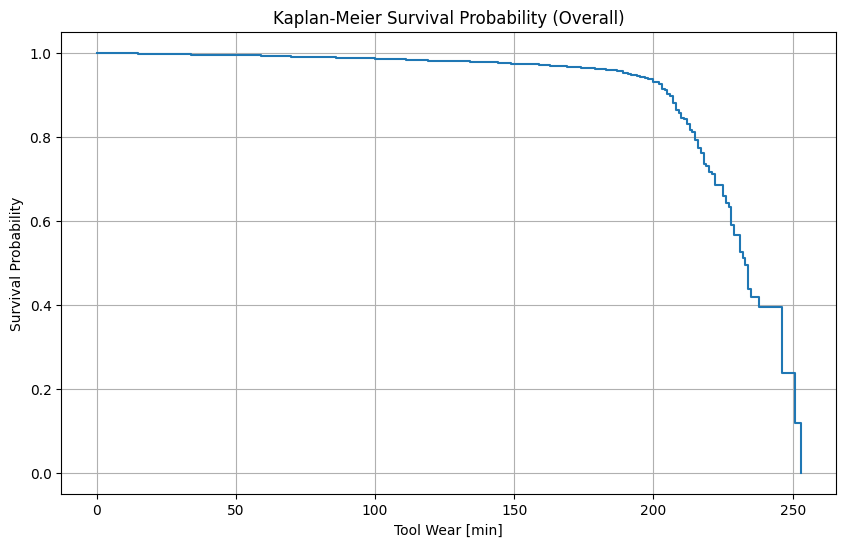

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 1. Manual Kaplan-Meier Calculation
def kaplan_meier(durations, events):
    sorted_indices = np.argsort(durations)
    durations = durations.iloc[sorted_indices].values
    events = events.iloc[sorted_indices].values

    unique_times = np.unique(durations)
    survival_probs = []
    current_survival = 1.0
    n_at_risk = len(durations)

    times = [0]
    probs = [1.0]

    for t in unique_times:
        d = np.sum(events[durations == t])
        n = n_at_risk
        current_survival *= (1 - d/n)
        times.append(t)
        probs.append(current_survival)
        n_at_risk -= len(durations[durations == t])

    return np.array(times), np.array(probs)

times, probs = kaplan_meier(df['Tool wear [min]'], df['Machine failure'])

# Plot KM
plt.figure(figsize=(10, 6))
plt.step(times, probs, where='post')
plt.title('Kaplan-Meier Survival Probability (Overall)')
plt.xlabel('Tool Wear [min]')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.savefig('km_survival_manual.png')

# 2. Predictive Model for Condition-Based Maintenance
# Predict 'Machine failure' using temperatures, speed, torque, and tool wear.
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = df[features]
y = df['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced') # Use balanced because of few failures
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

# Get feature importance (coefficients)
coefficients = pd.Series(model.coef_[0], index=features).sort_values()

# Print results for reasoning
print(f"Model AUC: {auc_score:.4f}")
print("Coefficients:")
print(coefficients)

# 3. Define Maintenance Policies
# Policy 1: Time-based (Tool Wear Threshold)
# Find tool wear at which survival probability falls below 95%
threshold_95 = times[np.where(probs < 0.95)[0][0]] if any(probs < 0.95) else max(times)
# Find tool wear at which survival probability falls below 90%
threshold_90 = times[np.where(probs < 0.90)[0][0]] if any(probs < 0.90) else max(times)

print(f"95% Survival Tool Wear: {threshold_95} min")
print(f"90% Survival Tool Wear: {threshold_90} min")

/tmp/ipython-input-2731599375.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.values, y=coefficients.index, palette='viridis')


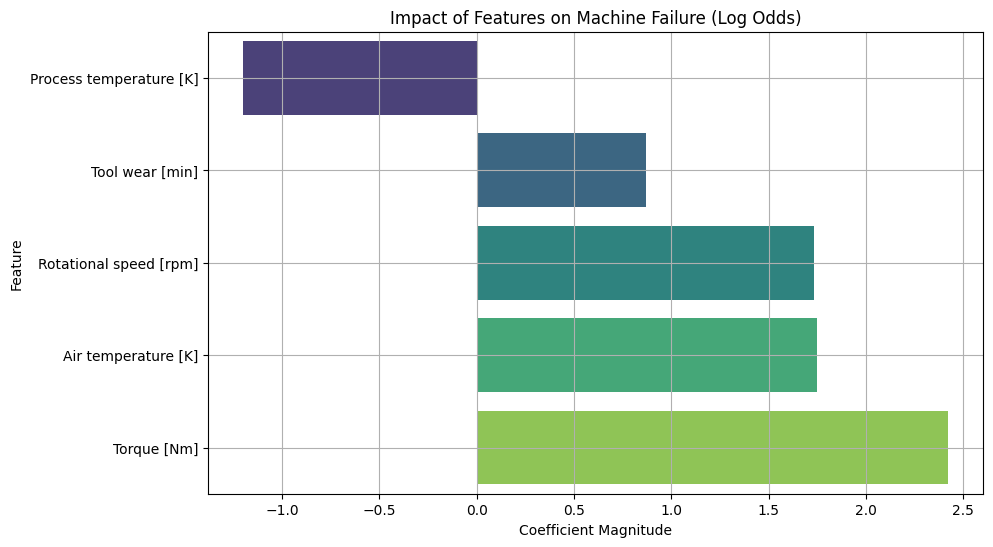

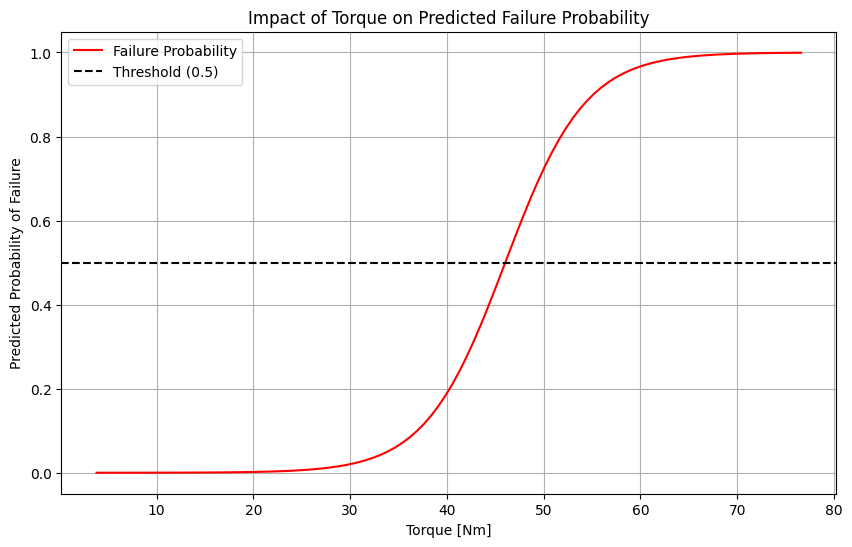

In [9]:
import seaborn as sns

# Visualizing feature importance for maintenance decisions
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.values, y=coefficients.index, palette='viridis')
plt.title('Impact of Features on Machine Failure (Log Odds)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.grid(True)
plt.savefig('feature_importance.png')

# Visualization: Probability of Failure vs. Torque (Strongest predictor)
# Create a sample range of torque to show the risk
torque_range = np.linspace(df['Torque [Nm]'].min(), df['Torque [Nm]'].max(), 100)
# Fix other variables at mean for prediction
other_means = df[features].mean()
# Create a dummy dataframe for prediction
dummy_df = pd.DataFrame([other_means]*100, columns=features)
dummy_df['Torque [Nm]'] = torque_range

# Scale the dummy dataframe using the same scaler
dummy_scaled = scaler.transform(dummy_df)
pred_probs = model.predict_proba(dummy_scaled)[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(torque_range, pred_probs, label='Failure Probability', color='red')
plt.axhline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.title('Impact of Torque on Predicted Failure Probability')
plt.xlabel('Torque [Nm]')
plt.ylabel('Predicted Probability of Failure')
plt.legend()
plt.grid(True)
plt.savefig('torque_failure_risk.png')